<a href="https://colab.research.google.com/github/DrZuse/RL_FPMI/blob/main/week10_Reinforce_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## week10
### REINFORCE in PyTorch
__This notebook is based on [Practical_RL week06](https://github.com/yandexdataschool/Practical_RL/tree/master/week06_policy_based) materials__

Just like we did before for q-learning, this time we'll design a pytorch network to learn `CartPole-v0` via policy gradient (REINFORCE).

Most of the code in this notebook is taken from approximate qlearning, so you'll find it more or less familiar and even simpler.

In [1]:
# # in google colab uncomment this

import os

os.system('apt-get install -y xvfb')
os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb')
os.system('apt-get install -y python-opengl ffmpeg')
os.system('pip install pyglet')

os.system('python -m pip install -U pygame --user')

print('setup complete')

# XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    %env DISPLAY = : 1

setup complete
Starting virtual X frame buffer: Xvfb.
env: DISPLAY=: 1


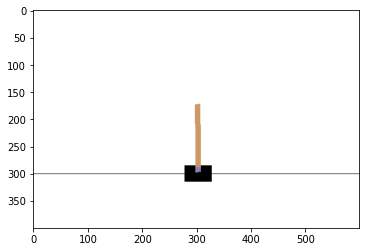

In [2]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0").env
example_state = env.reset()

plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states. Let's define such a model below.

In [3]:
import torch
import torch.nn as nn

In [4]:
sample = env.reset()
state_dim = sample.shape[0]
n_actions = env.action_space.n

In [5]:
# Build a simple neural network that predicts policy logits. 
# Keep it simple: CartPole isn't worth deep architectures.
model = nn.Sequential(
  #< YOUR CODE HERE: define a neural network that predicts policy logits >
  nn.Linear(state_dim, 128),
  nn.ReLU(),
  nn.Linear(128, 64),
  nn.ReLU(),
  nn.Linear(64, n_actions)
)

#### Predict function

In [6]:
from torch.nn import functional as F

In [7]:
def predict_probs(states):
    """ 
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :returns: numpy array of shape [batch, n_actions]
    """
    # convert states, compute logits, use softmax to get probability
    #<your code here >
    states = torch.FloatTensor(states)
    logits = model(states).detach()
    probs = F.softmax(logits, dim=-1).numpy()
    return probs #< your code >

In [8]:
test_states = np.array([env.reset() for _ in range(5)])
test_probas = predict_probs(test_states)
assert isinstance(
    test_probas, np.ndarray), "you must return np array and not %s" % type(test_probas)
assert tuple(test_probas.shape) == (
    test_states.shape[0], env.action_space.n), "wrong output shape: %s" % np.shape(test_probas)
assert np.allclose(np.sum(test_probas, axis=1),
                   1), "probabilities do not sum to 1"

### Play the game

We can now use our newly built agent to play the game.

In [9]:
def generate_session(t_max=1000):
    """ 
    play a full session with REINFORCE agent and train at the session end.
    returns sequences of states, actions and rewards
    """
    # arrays to record session
    states, actions, rewards = [], [], []
    s = env.reset()

    for t in range(t_max):
        # action probabilities array aka pi(a|s)
        action_probs = predict_probs(np.array([s]))[0]

        # Sample action with given probabilities.
        a = np.random.choice(
            np.arange(n_actions),
            p=action_probs
        ) #< your code >
        new_s, r, done, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    return states, actions, rewards

In [10]:
# test it
states, actions, rewards = generate_session()
print(f'states {states} \n actions {actions} \n rewards {rewards}')

states [array([-0.0125094 ,  0.03195347,  0.01767269, -0.04366204]), array([-0.01187034, -0.16341738,  0.01679945,  0.25454398]), array([-0.01513868, -0.35877512,  0.02189033,  0.55247804]), array([-0.02231419, -0.55419754,  0.03293989,  0.85197669]), array([-0.03339814, -0.74975272,  0.04997943,  1.1548329 ]), array([-0.04839319, -0.9454895 ,  0.07307608,  1.46275929]), array([-0.06730298, -1.14142691,  0.10233127,  1.77734626]), array([-0.09013152, -0.94759549,  0.13787819,  1.51815302]), array([-0.10908343, -1.14408921,  0.16824125,  1.85050434]), array([-0.13196521, -1.34061609,  0.20525134,  2.19036237])] 
 actions [0, 0, 0, 0, 0, 0, 1, 0, 0, 1] 
 rewards [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


### Computing cumulative rewards

In [11]:
def get_cumulative_rewards(rewards,  # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative returns (a.k.a. G(s,a) in Sutton '16)
    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute G_t = r_t + gamma*G_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    #<your code here >

    G = np.zeros_like(rewards, dtype=float)
    G[-1] = rewards[-1]
    for idx in range(-2, -len(rewards)-1, -1):
        G[idx] = rewards[idx] + gamma * G[idx+1]
    return G #< array of cumulative rewards >

In [12]:
get_cumulative_rewards(rewards)
assert len(get_cumulative_rewards(list(range(100)))) == 100
assert np.allclose(get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9), [
                   1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards(
    [0, 0, 1, -2, 3, -4, 0], gamma=0.5), [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards(
    [0, 0, 1, 2, 3, 4, 0], gamma=0), [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum  _{s_i,a_i} \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$


Following the REINFORCE algorithm, we can define our objective as follows: 

$$ \hat J \approx { 1 \over N } \sum  _{s_i,a_i} log \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$

When you compute gradient of that function over network weights $ \theta $, it will become exactly the policy gradient.


In [13]:
def to_one_hot(y_tensor, ndims):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    y_one_hot = torch.zeros(
        y_tensor.size()[0], ndims).scatter_(1, y_tensor, 1)
    return y_one_hot

In [14]:
# Your code: define optimizers
optimizer = torch.optim.Adam(model.parameters(), 1e-3)


def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-3):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """

    # cast everything into torch tensors
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int32)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)

    # predict logits, probas and log-probas using an agent.
    logits = model(states)
    probs = nn.functional.softmax(logits, -1)
    log_probs = nn.functional.log_softmax(logits, -1)

    assert all(isinstance(v, torch.Tensor) for v in [logits, probs, log_probs]), \
        "please use compute using torch tensors and don't use predict_probs function"

    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    log_probs_for_actions = torch.sum(
        log_probs * to_one_hot(actions, env.action_space.n), dim=1)
   
    # Compute loss here. Don't forget entropy regularization with `entropy_coef` 
    entropy = - torch.mean(torch.sum(probs * log_probs), dim=-1) #< your code >
    loss = - torch.mean(log_probs_for_actions * cumulative_returns) - entropy * entropy_coef  #< your code

    # Gradient descent step
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    #< your code >

    # technical: return session rewards to print them later
    return np.sum(rewards)

### The actual training

In [15]:
for i in range(100):
    rewards = [train_on_session(*generate_session())
               for _ in range(100)]  # generate new sessions
    print("mean reward:%.3f" % (np.mean(rewards)))
    if np.mean(rewards) > 500:
        print("You Win!")  # but you can train even further
        break

mean reward:26.690
mean reward:24.950
mean reward:46.730
mean reward:87.810
mean reward:63.090
mean reward:201.910
mean reward:133.330
mean reward:88.810
mean reward:57.850
mean reward:59.890
mean reward:131.890
mean reward:274.290
mean reward:271.380
mean reward:150.520
mean reward:115.650
mean reward:15.350
mean reward:9.770
mean reward:9.920
mean reward:9.660
mean reward:9.960
mean reward:9.880
mean reward:12.290
mean reward:10.250
mean reward:164.920
mean reward:214.560
mean reward:848.820
You Win!


### Video

In [16]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="videos", force=True)
sessions = [generate_session() for _ in range(100)]
env.close()

In [17]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be the _last_ video. Try other indices

### Bonus area: solving Acrobot-v1
Try to solve more complex environment using Policy gradient method.
*Hint: you will need add some imporovements to the original REINFORCE (e.g. Advantage Actor Critic or anything else).*

6 3


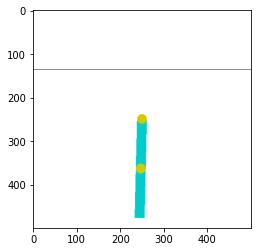

In [18]:
env = gym.make("Acrobot-v1")
env.reset()

plt.imshow(env.render("rgb_array"))
state_dim = env.reset().shape[0]
n_actions = env.action_space.n

print(state_dim, n_actions)

In [19]:
model = nn.Sequential(
  #< YOUR CODE HERE: define a neural network that predicts policy logits >
  nn.Linear(state_dim, 128),
  nn.ReLU(),
  nn.Linear(128, 64),
  nn.ReLU(),
  nn.Linear(64, n_actions)
)

In [20]:
# test it
states, actions, rewards = generate_session()
print(f'states {states} \n actions {actions} \n rewards {rewards}')

states [array([ 0.9953384 ,  0.09644414,  0.99999644, -0.00266822, -0.07831384,
        0.02020228]), array([ 0.99839978,  0.05654975,  0.9990249 ,  0.0441504 , -0.3119517 ,
        0.43327257]), array([ 0.99998977,  0.00452244,  0.99575651,  0.09202703, -0.19682898,
        0.03089682]), array([ 0.99982398, -0.018762  ,  0.99856847,  0.05348834, -0.03265963,
       -0.4138932 ]), array([ 9.99368983e-01, -3.55195025e-02,  9.99999903e-01,  4.39351948e-04,
       -1.33139625e-01, -1.10499517e-01]), array([ 0.99904892, -0.04360336,  0.99824093, -0.05928786,  0.05167422,
       -0.47746216]), array([ 0.999545  , -0.03016284,  0.98892211, -0.14843538,  0.07736965,
       -0.40184262]), array([ 0.99999841, -0.0017818 ,  0.96950555, -0.24506934,  0.19745082,
       -0.56251788]), array([ 0.99902532,  0.04414071,  0.93458111, -0.35575013,  0.24924104,
       -0.57231757]), array([ 0.99571801,  0.09244269,  0.89340767, -0.44924685,  0.22283846,
       -0.42681427]), array([ 0.99324154,  0.11606

In [21]:
# Your code: define optimizers
optimizer = torch.optim.Adam(model.parameters(), 1e-3)


def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-3):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """

    # cast everything into torch tensors
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int32)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)

    # predict logits, probas and log-probas using an agent.
    logits = model(states)
    probs = nn.functional.softmax(logits, -1)
    log_probs = nn.functional.log_softmax(logits, -1)

    assert all(isinstance(v, torch.Tensor) for v in [logits, probs, log_probs]), \
        "please use compute using torch tensors and don't use predict_probs function"

    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    log_probs_for_actions = torch.sum(
        log_probs * to_one_hot(actions, env.action_space.n), dim=1)
   
    # Compute loss here. Don't forget entropy regularization with `entropy_coef` 
    entropy = - torch.mean(torch.sum(probs * log_probs), dim=-1) #< your code >
    loss = - torch.mean(log_probs_for_actions * (cumulative_returns-torch.mean(cumulative_returns))) - entropy * entropy_coef  #< your code

    # Gradient descent step
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    #< your code >

    # technical: return session rewards to print them later
    return np.sum(rewards)

In [22]:
for i in range(100):
    rewards = [train_on_session(*generate_session())
               for _ in range(100)]  # generate new sessions
    print("mean reward:%.3f" % (np.mean(rewards)))
    if np.mean(rewards) > 500:
        print("You Win!")  # but you can train even further
        break

mean reward:-500.000
mean reward:-500.000
mean reward:-500.000
mean reward:-500.000
mean reward:-500.000
mean reward:-390.430
mean reward:-183.440
mean reward:-163.360
mean reward:-161.120
mean reward:-212.960
mean reward:-237.130
mean reward:-205.490
mean reward:-185.150
mean reward:-137.300
mean reward:-131.810


KeyboardInterrupt: ignored

In [23]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("Acrobot-v1"),
                           directory="videos", force=True)
sessions = [generate_session() for _ in range(100)]
env.close()

In [24]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be the _last_ video. Try other indices